# Setup

Running the simulations presumes the installation of specific packages, in particular Gammapy0.19. The easiest is maybe to simply recreate my conda environment, and run this notebook from there. Download the file env_swyft3-ext.yaml, and write the following in the terminal:

```
$conda env create --file env_swyft3-ext.yaml --name swyft3
$conda activate swyft3
```
Then download the IRF file *Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits* and *ALP_quick_sim.py*. If you place them in the same directory as this notebook, you should be set to run. Otherwise adapt the paths in the following cell:


In [1]:
import os

In [2]:
parent_dir = (os.getcwd()+"/").split('/notebooks/', 1)[0]
start_dir = os.getcwd()

In [3]:
ALP_file_dir = parent_dir+"/analysis_scripts/ALP_sim"             # The directory where ALP_quick_sim.py is placed. Can be empty if it's in same folder as notebook. 

In [4]:
import sys
if ALP_file_dir: sys.path.append(ALP_file_dir)   #!!! Change path to location of differential_counts.py and ALP_sim.py
from ALP_quick_sim import ALP_sim
from alp_swyft_simulator import ALP_SWYFT_Simulator

In [5]:
import numpy as np

In [6]:
import matplotlib.pyplot as plt

In [7]:
# import swyft.lightning as sl
import swyft

In [8]:
import torch

In [9]:
import scipy.stats as scist

In [10]:
import copy

In [11]:
import ipynbname

In [12]:
import pickle

In [13]:
import subprocess

In [14]:
from pytorch_lightning.loggers import WandbLogger
import wandb

In [15]:
files_name = ipynbname.name() + "_files"
files_dir = os.getcwd() + "/" + files_name 
store_name = ipynbname.name() + "_store"
store_dir = os.getcwd() + "/" + files_name + "/" + store_name

In [16]:
if not os.path.exists(files_dir):
    os.mkdir(files_dir)

In [17]:
rsync_result1 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/config_simulate.py', files_dir],
                                       capture_output = True, text=True)
rsync_result2 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/ALP_quick_sim.py', files_dir],
                                       capture_output = True, text=True)
rsync_result3 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/alp_swyft_simulator.py', files_dir],
                                       capture_output = True, text=True)
rsync_result4 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/simulate_batch.py', files_dir],
                                       capture_output = True, text=True)
rsync_result5 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/config_simulate_batch.py', files_dir],
                                       capture_output = True, text=True)
rsync_result6 = subprocess.run(['rsync', parent_dir+'/analysis_scripts/ALP_sim/config_pois.py', files_dir],
                                       capture_output = True, text=True)

In [18]:
A = ALP_sim(set_null=0, set_obs=0)

# Configuration

In [19]:
slurm = 1
conda_env = "swyft4-dev"
slurm_dir = '/home/gert/fox_hpc/ALPs_with_SWYFT/notebooks'

gpus = 0

max_time_sim = '00-04:00:00'
max_memory_sim = '40'
partition_sim = 'normal'
devel_sim = 0


account = 'ec12'
    

In [20]:
model_parameter_vals = [
            
    None,                 # mass m in neV
    None,               # coupling constant g in 10^(-11) /GeV
    
    5.75 * 1e-9,        # Amplitude of power law, in "TeV-1 cm-2 s-1" # 10e-6 
    2.36859,            # Spectral index of the PWL
    153.86,             # Reference energy (?) E0, In GeV
    819.72,             #Cut-off energy Ecut, in GeV
    
    
    25.,                # rms of B field, default = 10.
    39.,                # normalization of electron density, default = 39.
    4.05,               # second normalization of electron density, see Churazov et al. 2003, Eq. 4, default = 4.05
    500.,               # extension of the cluster, default = 500.
    80.,                # electron density parameter, see Churazov et al. 2003, Eq. 4, default = 80.
    280.,               # electron density parameter, see Churazov et al. 2003, Eq. 4, default = 200.
    1.2,                # electron density parameter, see Churazov et al. 2003, Eq. 4, default = 1.2
    0.58,               # electron density parameter, see Churazov et al. 2003, Eq. 4, default = 0.58
    0.5,                # scaling of B-field with electron denstiy, default = 0.5
    0.18,               # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012, default = 0.18
    9.,                 # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012, default = 9.
    -2.80               # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012, default = -2.80
            
]

poi_objects = {'model_parameter_vals':model_parameter_vals}
with open(files_dir+'/poi_objects.pickle','wb') as file:
    pickle.dump(poi_objects, file)
os.chdir(files_dir)
config_pois_result = subprocess.run(['python', files_dir+'/config_pois.py'], capture_output = True, text=True)

from param_function import param_function, param_names

os.chdir(start_dir)

A.full_param_vec = param_function

In [21]:
config_pois_result

CompletedProcess(args=['python', '/home/gert/ALPs_with_SWYFT/notebooks/ALP_g_dependent_files/config_pois.py'], returncode=0, stdout='\nWriting POI configuration function\nFinished writing parameter-extension function\n', stderr='')

In [22]:
n_sim = 10_000
n_cpus = 10
new_store = 0

bounds = [
    [-1,np.log10(50)],
]

truth = np.array([1])
truth2 = np.array([np.log10(0.8)]) 
truth3 = np.array([np.log10(0.2)])

truths = [truth, truth2, truth3]


In [23]:
A.configure_model(
    model="log",
    noise="poisson",
    null_params = [-np.inf, -np.inf],
    param_names = param_names,
    ALP_seed=0,
    floor=None,
    logcounts=True,
    residuals=True
)

In [24]:
A.configure_obs(
    nbins = 150,
    nbins_etrue = 450,
    emin = 6e1,
    emax = 3e3,
    livetime = 300,
    irf_file = parent_dir+"/IRFs/CTA/Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"
)

# Derived Values

In [25]:
simulation_batch_size = int(n_sim/n_cpus)

In [26]:
config_objects = {'A':A, 'n_sim':n_sim,'n_cpus':n_cpus, 'bounds':bounds, 'truths':truths, 'simulation_batch_size':simulation_batch_size, 
                  'store_name':store_name,'store_dir':store_dir, 'files_dir':files_dir, 'start_dir':start_dir, 'conda_env':conda_env,
                  'slurm':slurm, 'slurm_dir':slurm_dir, 'gpus':gpus,'max_time_sim':max_time_sim,'max_memory_sim':max_memory_sim,
                  'partition_sim':partition_sim,'devel_sim':devel_sim,'account':account}

In [28]:
with open(files_dir+'/config_objects.pickle','wb') as file:
    pickle.dump(config_objects, file)

# Simulation setup

In [29]:
A.generate_null()

Generating new null-hypothesis... [0.0, 0.0, 5.75e-09, 2.36859, 153.86, 819.72, 25.0, 39.0, 4.05, 500.0, 80.0, 280.0, 1.2, 0.58, 0.5, 0.18, 9.0, -2.8]
done.


In [30]:
sim = ALP_SWYFT_Simulator(A, bounds)

In [31]:
sim_objects = {'sim':sim}

In [32]:
with open(files_dir+'/sim_objects.pickle','wb') as file:
    pickle.dump(sim_objects, file)

# Defining observations

In [33]:
observations = []
for tru in truths:
    obs_exp=sim.generate_exp(tru)
    obs_data = sim.generate_data(obs_exp,tru)
    observations.append(swyft.Sample(data=obs_data, exp=obs_exp, params=tru))

IndexError: index 1 is out of bounds for axis 0 with size 1

# Simulating

In [31]:
if not os.path.exists(store_dir):
    os.mkdir(store_dir)
elif new_store:
    rm_result = subprocess.run(['rm','-r', store_dir],
                                       capture_output = True, text=True)
    if slurm:
        rm_slurm_result = subprocess.run(['rm','-r', slurm_dir+"/"+files_name+"/"+store_name],
                                           capture_output = True, text=True)
        
    
store = swyft.ZarrStore(store_dir + "/" + store_name)
store.init(
    N = n_sim,
    chunk_size=simulation_batch_size,
    shapes=sim.get_shapes_and_dtypes()[0],
    dtypes=sim.get_shapes_and_dtypes()[1],
)

In [32]:
os.chdir(files_dir)
config_simulate_result = subprocess.run(['python', files_dir+'/config_simulate.py'], capture_output = True, text=True)

!chmod +x simulate.sh

if not slurm:
    !./simulate.sh
else:
    if not os.path.exists(slurm_dir + "/" + store_name) or new_store:
        rsync_files_dir_result = subprocess.run(['rsync', '-r', files_dir, slurm_dir],
                                           capture_output = True, text=True)
    print("INSTRUCTIONS:")
    print("Go to " + slurm_dir + " and run simulate.sh, then continue here")

os.chdir(start_dir)

INSTRUCTIONS:
Go to /home/gert/fox_hpc/ALPs_with_SWYFT/notebooks and run simulate.sh, then continue here


# Importing and visualizing simulations

In [31]:
if slurm:
    rsync_slurm_dir_result = subprocess.run(['rsync', '-r', slurm_dir+"/"+files_name, start_dir],
                                       capture_output = True, text=True)

In [38]:
store = swyft.ZarrStore(store_dir + "/" + store_name)
samples = store.get_sample_store()

In [39]:
len(samples)

10000

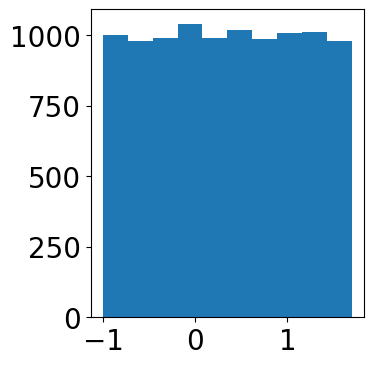

In [40]:
plt.figure(figsize=(12,4))
for i in range(len(bounds)):
    plt.subplot(1,3,i+1)
    plt.hist(samples['params'][:,i])

Checking that two simulations from the same parameters are identical

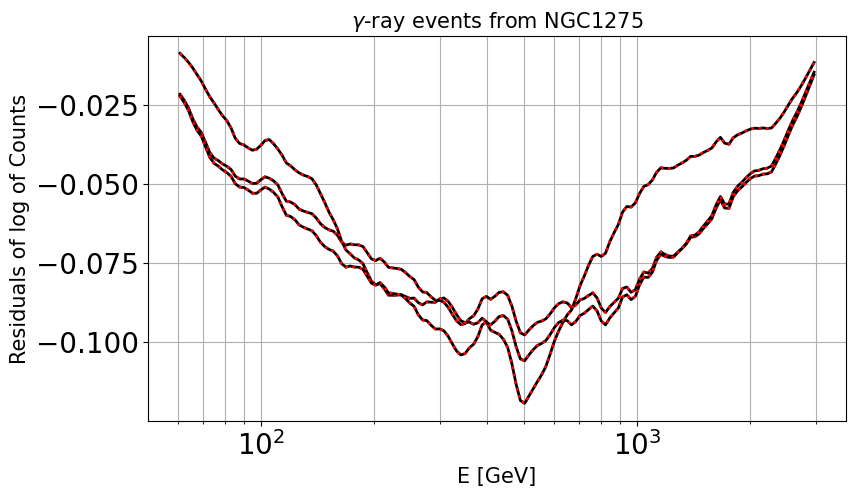

In [41]:
A.configure_plot(xmin=None, xmax=None, legend=0, logx=1, logy=0)
for i in range(min(len(samples),3)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color='k',linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_obs=0)
    A.compute_case(new_fig=0,new_counts=1,color='r',linestyle=":",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_obs=0)


Visualizing a selection of simulations in the training set:

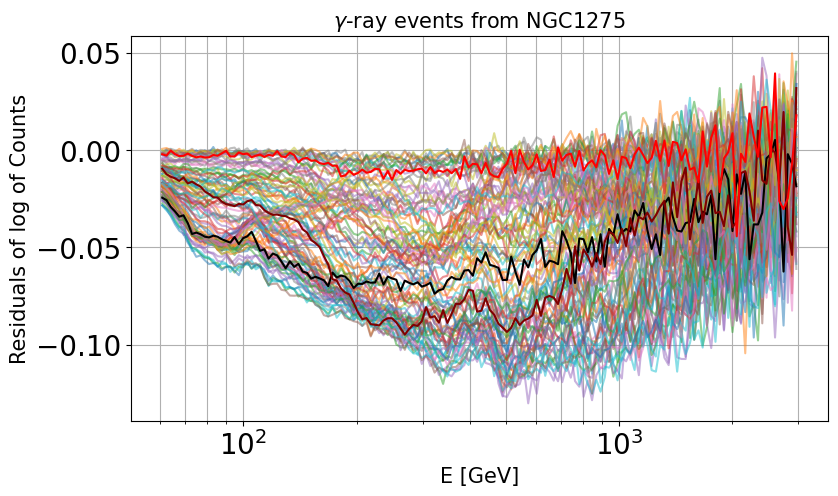

In [58]:
# colors = ['r','#FFA500','y','g','c','b','m']
A.configure_plot(xmin=None, xmax=None, legend=0, logx=1, logy=0)
for i in range(min(len(samples),100)):
    A.configure_model(params=samples[i]['params'])
    A.import_counts(obs=samples[i]['data'],exp=samples[i]['exp'])
    new_fig = 1 if i==0 else 0
    A.compute_case(new_fig=new_fig,new_counts=0,color=None,color_obs=None,linestyle="-",
                   label_exp=0,label_obs=False, errorbands=False, errors=False, plot_exp=0, transparency=0.5)

colors = [
    (0,0,0),
    (0.5,0,0),
    (1,0,0),
    
]

for i,obs in enumerate(observations):
    A.configure_model(params=obs['params'])
    A.import_counts(obs=obs['data'],exp=obs['exp'])
    shade = i/(len(observations)+1)
    A.compute_case(new_fig=0,new_counts=0,color='k',color_obs=colors[i],linestyle="-",label_exp=0,label_obs=0,
                   errorbands=0, errors=0, plot_exp=0)
    # A.compute_case(new_fig=0,new_counts=0,color='b',color_obs=colors[i],linestyle="-",label_exp=0,label_obs=0,
    #                    errorbands=0, errors=0, plot_obs=0) 

In [ ]:
observations[1]['params']

In [40]:
[1,np.log10(0.8)][1]

-0.09691001300805639

In [42]:
A.null_params

[-inf]

In [37]:
A.simulate([1,np.log10(0.8)])

[10, 0.8, 5.75e-09, 2.36859, 153.86, 819.72, 25.0, 39.0, 4.05, 500.0, 80.0, 280.0, 1.2, 0.58, 0.5, 0.18, 9.0, -2.8]
Generating new null-hypothesis... 

IndexError: list index out of range

In [ ]:
A.emin

In [ ]:
A.emax

In [ ]:
A.configure_model(logcounts=0, residuals=0,ALP_seed=0)

In [38]:
A.model([10,0.8])

[10, 0.8, 5.75e-09, 2.36859, 153.86, 819.72, 25.0, 39.0, 4.05, 500.0, 80.0, 280.0, 1.2, 0.58, 0.5, 0.18, 9.0, -2.8]
Generating new null-hypothesis... 

IndexError: list index out of range

In [ ]:
A.simulate(observations[1]['params'])

In [ ]:
A.full_param_vec(observations[1]['params'])

In [ ]:
A.simulate([-np.inf])

In [ ]:
A.counts_null

In [ ]:
A.ALP_seed

# Training

In [43]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.norm = swyft.networks.OnlineStandardizingLayer(torch.Size([A.nbins]), epsilon=0)
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features = A.nbins, 
            num_params = len(bounds), 
            varnames = sim.A.param_names)
        self.learning_rate = 0.0005
    
    def forward(self, A, B):
        data = self.norm(A['data'])
        return self.logratios(data, B['params'])

In [44]:
network = Network()

In [50]:
wandb_logger = WandbLogger(log_model='all')

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [45]:
trainer = swyft.SwyftTrainer(
    accelerator = 'cpu', precision = 64, logger=wandb_logger #, min_epochs =25, 
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:
dm = swyft.SwyftDataModule(samples)

In [47]:
trainer.fit(network, dm)

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type                     | Params
-------------------------------------------------------
0 | norm      | OnlineStandardizingLayer | 0     
1 | logratios | LogRatioEstimator_1dim   | 26.9 K
-------------------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.216     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./lightning_logs/a9c28yrs/checkpoints/epoch=15-step=4000.ckpt


In [48]:
prior_samples = sim.sample(100_000, targets=['params'])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [56]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,▇█▅▃▅▂▃▂▄▃▃▃▃▄▃▆▃▅▂█▂▂▂▂▂▂▂▃▃▃▅▂▄▁▄▁▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▅▇▆▃▂▄▂▂▁▂▂▂▁▁▂▂▂▂▂
epoch,20
train_loss,-0.99954
trainer/global_step,5249
val_loss,-0.86046


# Inference

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/home/gert/anaconda3/envs/swyft4-dev/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

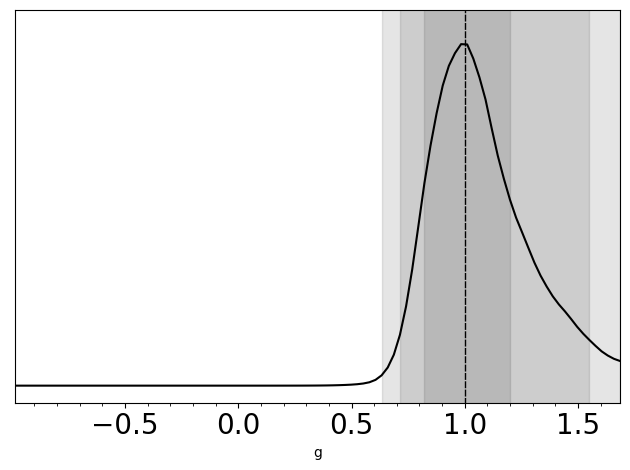

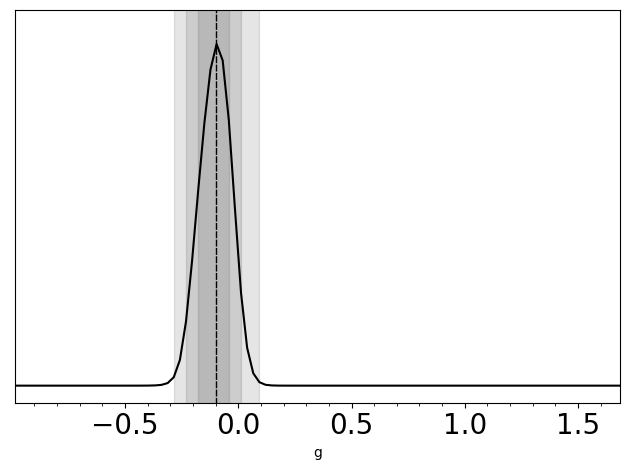

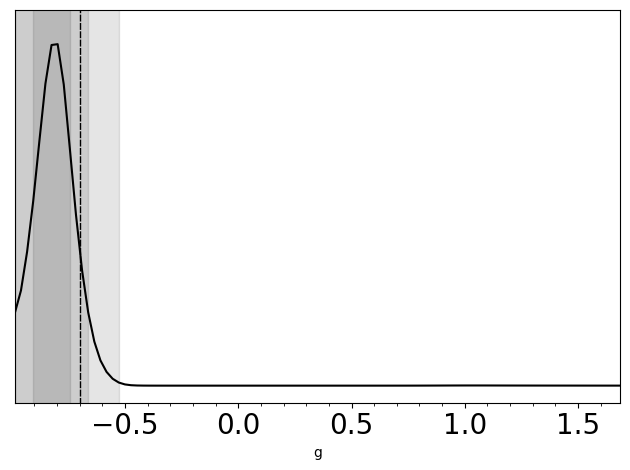

In [49]:
for j in range(len(truths)):
    logratios = trainer.infer(
                            network,
                            observations[j],
                            prior_samples
                            )
    
    swyft.plot_posterior(logratios, A.param_names, truth={A.param_names[i]:truths[j][i] for i in range(len(truths[j]))})